Import packages

In [1]:
# import the necessary packages
# ResNet CNN
from tensorflow.keras.applications import ResNet50 # pre-trained model; classifier
from tensorflow.keras.applications.resnet import preprocess_input # assoc with resnet, preproc and scale
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils # decode predictions
from imutils.object_detection import non_max_suppression # suppress weak boxes
from submodules.detection_helpers import sliding_window
from submodules.detection_helpers import image_pyramid
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils # resizing, aspect ratio
import time # measure step duration, tune
import cv2

Display function in Jupyter Notebookes

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

Implement image pyramid and sliding window

In [3]:
# image = input image
# step = how many pixels to skip in both x, y direction
	# step 1 = each/every pixel
	# step determined per dataset
	# 4 or 8 is common
# ws = window size to extract image size from
def sliding_window(image, step, ws):
	# loop over rows determining range of y values
	for y in range(0, image.shape[0] - ws[1], step):
		# loop over columns range of x values
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [4]:
# image = input image
# scale = how much the image is resized at each layer
	# smaller = more layers
# minSize = control to stop loop at this size
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image, bottom layer
	yield image

	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		# resize the image while maintaining aspectr ratio
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

Use Keras and TensorFlow to turn pre-trained classifier into Object Detector

In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/navy.jpg",
	"size": "(300, 150)", # tune this
	"min_conf": 0.9, # filter out weak detections
	"visualize": -1 # debugging visualize sliding window
}

In [6]:
# initialize variables used for the object detection procedure
# set constant width, starting point for img pyramid
WIDTH = 600
# how much each image is resized, balance speed vs. accuracy
PYR_SCALE = 1.5
# how many pixels to skip to the left, if end then down, speed vs accuracy
WIN_STEP = 16
# controls aspect ratio of objects to detect
ROI_SIZE = eval(args["size"])
# https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/
# resnet required
INPUT_SIZE = (224, 224)

In [7]:
# load network weights from disk
print("[INFO] loading network...")
# loads the pre-trained resnet model
model = ResNet50(weights="imagenet", include_top=True)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
# grab original spatial dimensions
(H, W) = orig.shape[:2]

[INFO] loading network...


In [8]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [9]:
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])

	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		# x scale
		x = int(x * scale)
		# y scale
		y = int(y * scale)
		# w scale
		w = int(ROI_SIZE[0] * scale)
		# h scale
		h = int(ROI_SIZE[1] * scale)

		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)

		# update our list of ROIs and associated coordinates
		rois.append(roi)
		# top-left and bottom-right, draw edges
		locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if args["visualize"] > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)

			# show the visualization and current ROI
			plt_imshow("Visualization", clone)
			plt_imshow("ROI", roiOrig)

In [10]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 0.22369 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 20.68276 seconds


In [11]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'fireboat'


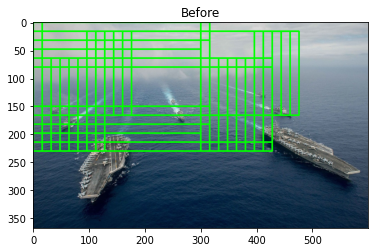

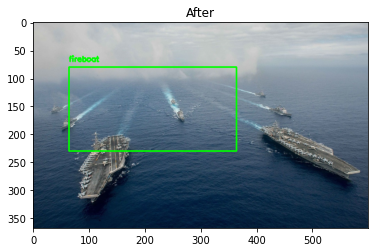

[INFO] showing results for 'aircraft_carrier'


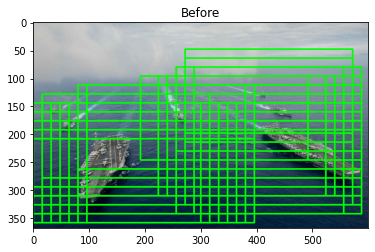

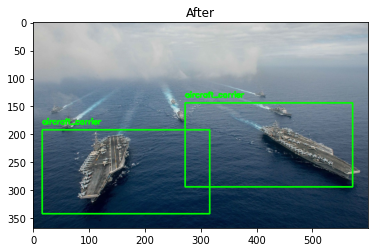

In [12]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = orig.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)
